In [1]:
import pandas as pd
import numpy as np
import string, math, collections, typing, warnings, pickle, random
import imblearn, matplotlib
from matplotlib import pyplot as plt
from sklearn import decomposition, manifold

In [2]:
#configurations
warnings.filterwarnings('ignore')

In [3]:
#global variables
DATA_DIR = 'D:/data'
OUTPUT_DIR = './tsne'
METHODS = ['none', 'cnn', 'border', 'smote', 'over', 'under', 'aug', 'aug_fine']
MODEL = 'bert-base-uncased'
DATASETS = ['antisemitism_two', 'antisemitism_four', 
            'antisemitism_five',  'disaster', 
            'clothing_topic', 'clothing_rating', 'cyberbullying',
            'website', 'news_mild_multi', 'news_mild_two',
            'news_multi', 'news_semi_multi',
            'news_severe_multi', 'news_severe_two',
            ]
PCA_DIMS = 100
NUM_ROWS = 2
TSNE_DIMS = 2
TSNE_PERPLEXITY = 10
TSNE_ITER = 300 #number of iterations for t-SNE
OUTLIER_CONSTANT = 1.5 #outlier constant used as coefficient for IQR when removing outliers
colors = list(matplotlib.colors.CSS4_COLORS)
random.shuffle(colors)

In [4]:
#helper functions
def remove_below_threshold(array: np.ndarray, value_array: np.ndarray, threshold: float) -> np.ndarray:
    '''Remove all elements from an array where same index in another array is greater than a particular threshold.'''
    return np.array([value for i, value in enumerate(array) if value_array[i] <= threshold])

def pca_reduce(array: np.ndarray) -> np.ndarray:
    '''Reduce the dimensions to a smaller number using PCA.'''
    dims = min(PCA_DIMS, array.shape[0], array.shape[1])
    pca = decomposition.PCA(n_components=dims)
    return np.array(pca.fit_transform(array))

def tsne_reduce(array: np.ndarray) -> np.ndarray:
    '''Reduce to two-dimensional data using PCA and t-SNE.'''
    #array = pca_reduce(array) #get reasonable number of dimensions to then use t-SNE on.
    tsne = manifold.TSNE(n_components=TSNE_DIMS, perplexity=TSNE_PERPLEXITY, n_iter=TSNE_ITER, n_jobs=10)
    return np.array(tsne.fit_transform(array))

def remove_outliers(inputs: np.ndarray, outlier_coef: float = OUTLIER_CONSTANT) -> np.ndarray:
    '''Remove outliers from numpy array. Removes from inputs, and removes values of same index from outputs and mask.'''
    upper_quartile = np.percentile(inputs, 75, axis=0)
    lower_quartile = np.percentile(inputs, 25, axis=0)
    mean = np.mean(inputs, axis=0)
    iqr = (upper_quartile - lower_quartile) * outlier_coef
    max_dist = max(np.linalg.norm(mean + upper_quartile + iqr), np.linalg.norm(mean - lower_quartile - iqr))
    norms = np.linalg.norm(inputs-mean, axis=1)
    return remove_below_threshold(inputs, norms, max_dist)

In [5]:
#primary functions
def visualize_tsne(method: str, dataset: str, ax: matplotlib.axes.Axes) -> None:
    '''Perform the t-SNE visualization.'''
    with open(f'{DATA_DIR}/{method}/{MODEL}/train-input-{dataset}', 'rb') as f:
        inputs = pickle.loads(f.read())
    with open(f'{DATA_DIR}/{method}/{MODEL}/train-output-{dataset}', 'rb') as f:
        outputs = pickle.loads(f.read())
    
    size = 2000/len(outputs)
    opacity = max(min(500/len(outputs), 1), 0.05)
    inputs = remove_outliers(tsne_reduce(inputs))
    
    for index, classification in enumerate(list(set(list(outputs)))):
        temp_inputs = np.array([item for i, item in enumerate(inputs) if outputs[i] == classification])
        ax.scatter(temp_inputs[:, 0], temp_inputs[:, 1], s=size, alpha=opacity)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(f'{method} - {dataset}')

antisemitism_two


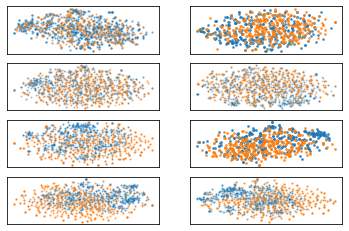

antisemitism_four


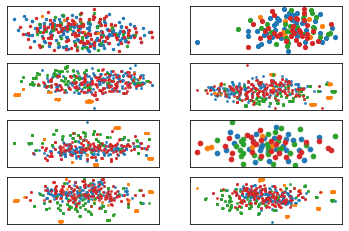

antisemitism_five


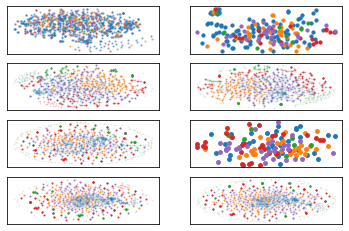

disaster


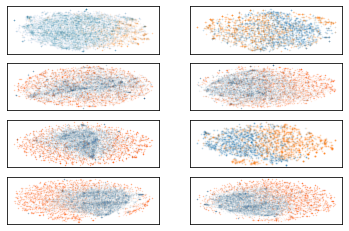

clothing_topic


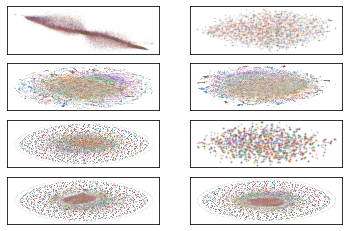

clothing_rating


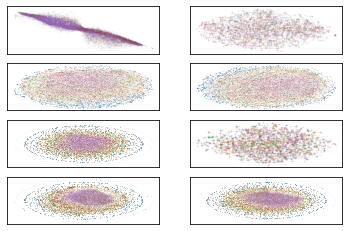

cyberbullying


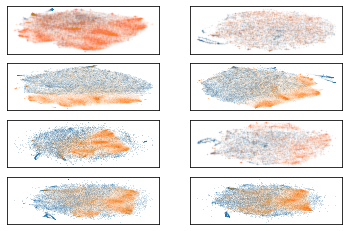

website


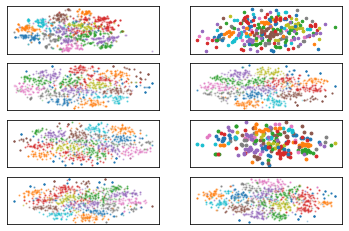

news_mild_multi


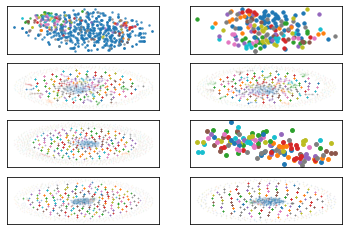

news_mild_two


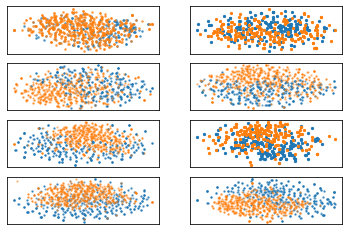

news_multi


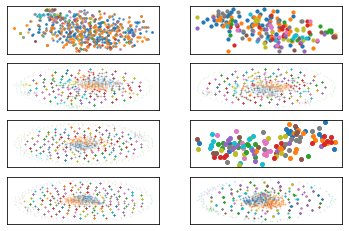

news_semi_multi


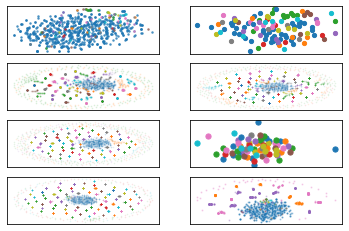

news_severe_multi


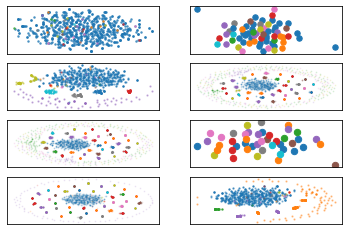

news_severe_two


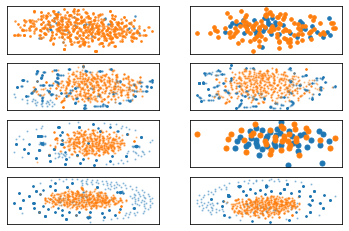

In [6]:
for dataset in DATASETS:
    print(dataset)
    fig, axs = plt.subplots(len(METHODS) // NUM_ROWS, NUM_ROWS)
    for i, method in enumerate(METHODS):
        ax = axs[i // NUM_ROWS, i % NUM_ROWS]
        visualize_tsne(method, dataset, ax)
    plt.show()